## CIR Model to simulate changes in Interest Rates and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates. In order to do this, we apply the following equation, which is pretty similar to the one we've seen for Brownian motion:

$$ dr_{t} = a(b-r_{t})dt + \sigma\sqrt{r_{t}} dW_{t} $$


where $b$ is the mean of the interest rate in the long term, and $a$ measures how fast you reverse to the mean. This is basically what we've seen already in Week 3. Remember as well that $dW$ represents a random number than follows a standard Gaussian distribution.

In essence, this equation is a mean reversion model which is a function of how far you are from the mean return, how long it takes to get back to the mean, plus some shock (the Brownian motion part).

### Short Rate vs Annualized

In general, if we compound every 1/N f a year (i.e. we compound N times a year), we get:

$$ (1 + \frac{r}{N})^{N} $$

You can check that the bigger the N, the bigger the compound is by the end of the year, but,as you might have guessed, in the limit of $N \rightarrow \infty$, the expression converges to $e$. If we take this limit, we can find what we call instantaneous rate:

$$ r_{inst} = ln(1+r_{annual}) $$

With this in mind, we can build a function to generate or CIR model:

In [12]:
import numpy as np 
import pandas as pd
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    
    """
    Implements the CIR model for interest rates
    """
    
    if r_0 is None:
        r_0 = b
        
    r_0 = erk.ann_to_inst(r_0)
    dt= 1/steps_per_year
    #We generate random numbers with mean 0 and standard deviation sigma*sqrt(dt).
    # The scale should be 1 because we are using standard Gaussian distribution,
    # but this makes the following code faster
    num_steps = int(n_years*steps_per_year) + 1 #we add the one because the first row would be the initial rate
    shock = np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))  #dW, Brownian motion
    rates = np.empty_like(shock) #empty array with the size of shock
    rates[0] = r_0
    
    for step in range(1,num_steps): 
        r_t=rates[step-1] 
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = r_t + d_r_t #these rates are instantaneous. In particular, this is the r_{t+1},
        #which we are storing for the next loop, which corresponds to t+1, and with which we will
        #obtain dr_{t+1}
        
    return pd.DataFrame(data=erk.inst_to_ann(rates), index=range(num_steps)) #Return everything annualized

Let's do it as a widget:

In [14]:
controls = widgets.interactive(erk.show_cir_rates,
                              r_0=(0,.15,.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0,.1,.01),
                              n_scenarios=(1,100))
controls

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

We can see the following:

$\sigma$ makes the curves noisier.

$a$, the speed, makes the curve tend to $b$ faster or slower.

CIR model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate. In order to do so, we have to use the following equation:

$$ P(t,T) = A(t,T)e^{-B(t,T)r_{t}} $$


where

$$ A(t,T) = \left( \frac{2he^{(a+h)\frac{\tau}{2}}}{2h + (a+h)(e^{\tau h} -1)} \right)^{\frac{2ab}{\sigma^{2}}} $$

$$ B(t,T) = \frac{2(e^{\tau h}-1)}{2h + (a+h)(e^{\tau h} -1)} $$

$$ h = \sqrt{a^{2} + 2\sigma^{2}} $$

$$ \tau = T - t $$

Now we can update our function so that it also returns prices and not only rates.

In [15]:
import math

In [16]:
def cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    
    """
    Implements the CIR model for interest rates
    """
    
    if r_0 is None:
        r_0 = b
        
    r_0 = ann_to_inst(r_0)
    dt= 1/steps_per_year
    #We generate random numbers with mean 0 and standard deviation sigma*sqrt(dt).
    # The scale should be 1 because we are using standard Gaussian distribution,
    # but this makes the following code faster
    num_steps = int(n_years*steps_per_year) + 1 #we add the one because the first row would be the initial rate
    shock = np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))  #dW, Brownian motion
    rates = np.empty_like(shock) #empty array with the size of shock
    rates[0] = r_0
    
    ## For Price Generation
    
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm,r):
        
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P= _A*np.exp(-_B*r)
        return _P
    
    prices[0] = prices(n_years,r_0)
    
    for step in range(1,num_steps): 
        r_t=rates[step-1] 
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) #these rates are instantaneous. In particular, this is the r_{t+1},
        #which we are storing for the next loop, which corresponds to t+1, and with which we will
        #obtain dr_{t+1}
        #Generates prices at time t as well
        prices[step] = price(n_years-step*dt,rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps)) #Return everything annualized
    prices = pd.DataFrame(data=prices, index=range(num_steps)) #Return everything annualized
    
    return rates, prices


In [17]:
controls = widgets.interactive(erk.show_cir_prices,
                              r_0=(0,.15,.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0.001,.1,.01),
                              n_scenarios=(1,100))
controls

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

What is this showing? That no matter the variables, the price of the bond will eventually converge to 1.

Let's simulate now how some cash evolves in 10 years. We will use as initial investment the money we need to obtain 1 dollars in 10 years if we use bonds. As we have seen, with bonds we would obtain this dollar at the end of the period no matter what. However, if we invest in cash, it might not be the case:

<AxesSubplot:>

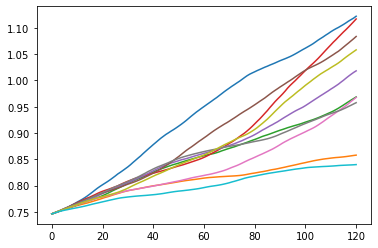

In [30]:
zc_0 = erk.pv_simple(pd.Series(data=[1], index=[10]), r=0.03) #present value of 1 10-year-dollar. We have to give parameters as list 
#it is the starting point of the graph 

rates, bond_prices = erk.cir(n_years=10,r_0=0.03,n_scenarios=10)

liabilities = bond_prices #liabilities are just the change in bond prices in this case

av_zc_bond = 1*bond_prices #evolution of asset value. We put a 1 to state that we have to multiply by the number
#of bonds we can buy with initial investment. Since in this case our investment is the initial price of a bond,
# we can only buy one bond.

av_cash = zc_0*(rates/12 +1).cumprod() #they are annualized rates, you have to divide by 12

av_cash.plot(legend=False)

As you can see, some assets surpass the dollar, but some others not, so there is no fixed, safe return with cash. Let's have a look at the zero-coupon bonds:

<AxesSubplot:>

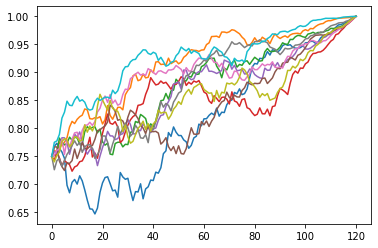

In [31]:
av_zc_bond.plot(legend=False)

In this case, we have a lot more noise, but all the scenarios meet the requirement that by the end of the period, we have 1 dollar (because we started with the required initial investment). Another good way of looking at cash and bond is by using the funding ratio:

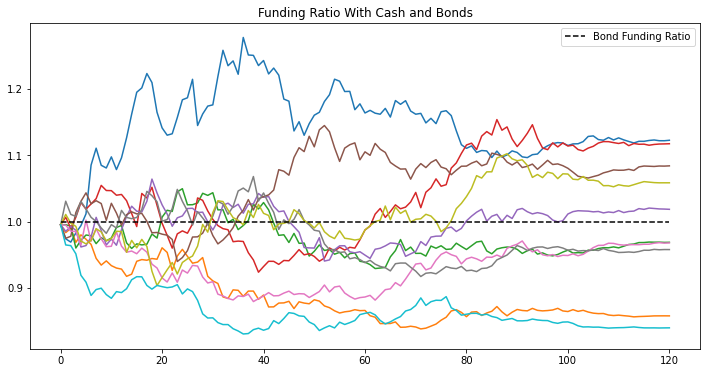

In [32]:
fig, ax1 = plt.subplots(1, 1,figsize=(12,6))
ax1.plot(av_cash/liabilities,label="_nolabel_")
ax1.plot((av_zc_bond/liabilities).loc[:,0],label="Bond Funding Ratio",linestyle="--",color="black") #we plot first scenario, they are all the same
ax1.set_title("Funding Ratio With Cash and Bonds")
ax1.legend()


So in this particular case (it might change with different simulations), half cash scenarios would be sufficiently funded, but the other half would be underfunded. Let's do another bigger simulation and see how the Terminal Funding Ratio (Funding Ratio by the end of the period) with cash is distributed:

In [33]:
#Code repetead, but number of scenarios change


zc_0 = erk.pv_simple(pd.Series(data=[1], index=[10]), r=0.03) #present value of 1 10-year-dollar. We have to give parameters as list 
#it is the starting point of the graph 

rates, bond_prices = erk.cir(n_years=10,r_0=0.03,n_scenarios=10000)

liabilities = bond_prices #liabilities are just the change in bond prices in this case

av_zc_bond = 1*bond_prices #evolution of asset value. We put a 1 to state that we have to multiply by the number
#of bonds we can buy with initial investment. Since in this case our investment is the initial price of a bond,
# we can only buy one bond.

av_cash = zc_0*(rates/12 +1).cumprod() #they are annualized rates, you have to divide by 12

<AxesSubplot:ylabel='Frequency'>

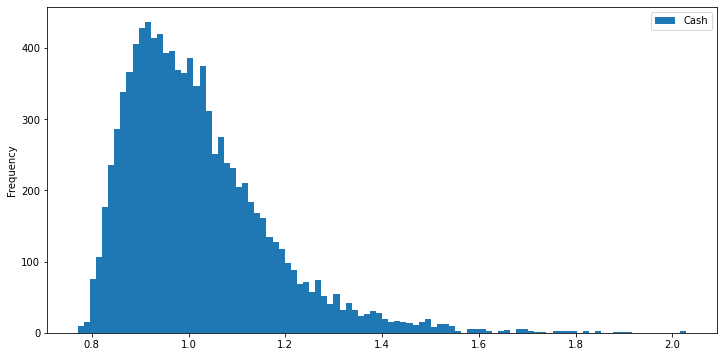

In [34]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]

tfr_cash.plot.hist(label="Cash", figsize=(12,6),legend="True", bins=100)


So it is hugely positively skewed (lots of small losses and few big gains). This tells us that you will usually be behind the money you need, but not too much.

Using the CIR strategy only makes sense if you have enough money to meet a given goal, as for any scenario it will virtually end up in the same point. If at the present time you are underfunded (e.g. you need 0.5 dollars to follow CIR strategy but you only have 0.4), it might make sense to you to invest in cash, as it might give you the chance to surpass the returns of a bond investment (but it might happen the opposite as well).